In [1]:
# Data augmentations
BATCHSIZE = 1
NUM_EPOCHS = 10
RandomHorizontalFlipProbablility = 0.5
RandomVerticalFlipProbablility = 0.5
RandomRotationAngle = 50

hasBackground = False
brightness = None
# Should also consider brightness 

testName = f'ResNet3D_13SlicesPicked_epochs-{NUM_EPOCHS}_batchsze-{BATCHSIZE}_onLaptop_3classes_dataArgs_hasBackground-{hasBackground}_evenWeights-{False}_HFlip-{RandomHorizontalFlipProbablility}_\
VFlip-{RandomVerticalFlipProbablility}_rotation-{RandomRotationAngle}_brightness-{brightness}'
testPathName = 'Tests/'+testName


# Balance the classes used in the model
class1Percentage = (0.3333/16)
class2Percentage = (0.3333/30)
class3Percentage = (0.3333/24)
weightsForClasses = [class1Percentage / (class1Percentage+class2Percentage+class3Percentage) , class3Percentage / (class1Percentage+class2Percentage+class3Percentage), class3Percentage / (class1Percentage+class2Percentage+class3Percentage)]
# print(weightsForClasses)

In [3]:
# Convert to python script, remember to delete/comment the next line in the actual file
# ! jupyter nbconvert --to python imageSegmentationMultipleSingleSlice.ipynb

In [91]:
# Image reading and file handling 
import pandas as pd
import SimpleITK as sitk 
import os 
import shutil

# Image agumentaitons
import numpy as np
import cv2

# import scipy

# Information saving
import pickle

# Train test set spliting
from sklearn.model_selection import train_test_split

# Dataset building
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import random
import copy

# Model building
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

# Evaluation metrics and Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
## Download necessary packages 
# ! pip install matplotlib opencv-python scipy simpleitk pandas openpyxl scikit-learn nbconvert
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 
# ! pip install foundation-cancer-image-biomarker -qq
# ! pip install foundation-cancer-image-biomarker
# ! pip install torchio

## optional packages:
# ! pip install pynrrd

## Check python version and packages
# ! python --version
# ! pip freeze > research.txt

## Get the data from the .xsxl file

In [3]:
columns = ['TAPS_CaseIDs_PreNAT','RECIST_PostNAT', 'Slice_Thickness']
data = pd.read_excel('PDAC-Response_working.xlsx', header=None,names = columns)
data.drop(0, inplace=True) # Remove the header row
data=data.sort_values(by=['TAPS_CaseIDs_PreNAT'])

# # Get the entire datasheet
cases = list(data['TAPS_CaseIDs_PreNAT'])
recistCriteria = list(data['RECIST_PostNAT'])

# # Remove all folders that have >13 slices in the datasheet
# data.drop(data[data['Slice_Thickness'] <= 13].index, inplace = True)
# print(list(data['Slice_Thickness']))
# cases = list(data['TAPS_CaseIDs_PreNAT'])
# recistCriteria = list(data['RECIST_PostNAT'])


## Perform preprocessing on multiple images


In [4]:
def window_image_to_adbomen(image, window_center, window_width):
    
    img_max = window_center + int(window_width / 2)
    img_min = window_center - int(window_width / 2)
    return np.clip(image, img_min, img_max)

def centerXYOfImage(overlay_mask, segment_mask, segmentedSlices, padding=25):
    """ 
    Centers the X and Y of the image to crop the image. segmentedSlices is given as an array of z-value slices because the same approach to x_indicies and y_indicies does not work on overlay_segment (works for x and y though)
    """
    x_indices, y_indices, _ = np.where(segment_mask == 1)
    # Get the bounding box for x and y dimensions
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()

    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2

    width = abs(max_x - min_x) // 2
    height = abs(max_y - min_y) // 2

    
    # Get the dimensions of the cropped image
    start_x = max(0, center_x - width - padding)
    end_x = min(segment_mask.shape[0], center_x + width + padding)
    start_y = max(0, center_y - height - padding)
    end_y = min(segment_mask.shape[1], center_y + height + padding)

    # # Adjust the crop region if it's smaller than 100x100
    # if end_x - start_x < 100:
    #     if start_x == 0:
    #         end_x = min(segment_mask.shape[0], 100)
    #     elif end_x == segment_mask.shape[0]:
    #         start_x = max(0, segment_mask.shape[0] - 100)
    # if end_y - start_y < 100:
    #     if start_y == 0:
    #         end_y = min(segment_mask.shape[1], 100)
    #     elif end_y == segment_mask.shape[1]:
    #         start_y = max(0, segment_mask.shape[1] - 100)

    segmentedSlices = np.sort(np.array(segmentedSlices))
    return overlay_mask[start_x:end_x, start_y:end_y, np.array(segmentedSlices)]

In [5]:
def convertNdArrayToCV2Image(image, resolution = (64,64)):
    """ Converts a numpy array to a cv2 image """
    image = np.array(image, dtype=np.uint8)
    image = cv2.resize(image, resolution)
    return image

def makeAlign(image1,image2):
    image1.SetDirection(image2.GetDirection())
    image1.SetOrigin(image2.GetOrigin())
    image1.SetSpacing(image2.GetSpacing())
    return image1, image2

def isAligned(image1, image2):
    return image1.GetDirection() == image2.GetDirection() and image1.GetOrigin() == image2.GetOrigin() and image1.GetSpacing() == image2.GetSpacing()   

def resampleSizes(wholeHeader, segmentHeader):
    """ 
    Resamples the sitk image to have the same size based on the one with the largest size.
    """
    if wholeHeader.GetSize()[-1] >= segmentHeader.GetSize()[-1]:
        imageLarge = wholeHeader
        imageSmall = segmentHeader
        wholeThenSegmentOrder = True
    else:
        imageLarge = segmentHeader
        imageSmall = wholeHeader 
        wholeThenSegmentOrder = False

    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(imageLarge)  
    resample.SetInterpolator(sitk.sitkLinear)  # Choose the interpolation method (sitkLinear, sitkNearestNeighbor, etc.)
    resample.SetDefaultPixelValue(0)  # Set default pixel value for areas outside the original image

    imageSmall = resample.Execute(imageSmall)

    print(f'imageLarge: {imageLarge.GetSize()}')
    print(f'imageSmall: {imageSmall.GetSize()}')
    

    if wholeThenSegmentOrder:
        return imageLarge, imageSmall # whole, then segment
    else:
        return imageSmall, imageLarge # segment, then whole

In [6]:
def twoImageAlignProceess(wholeHeader,segmentHeader,verbose):    

    error = False
    # Check if the images are aligned
    wholeHeader, segmentHeader = makeAlign(wholeHeader, segmentHeader)
    imagesAreAligned = isAligned(wholeHeader, segmentHeader)
    print(f'Are the two images aligned now?: {imagesAreAligned}' if verbose==2 else '',end='')

    if not imagesAreAligned:
        error = True
        return None, None, True
    
    # Set the spacing of the image to 1x1x1mm voxel spacing
    wholeHeader.SetSpacing([1,1,1])
    segmentHeader.SetSpacing([1,1,1])
    imagesSpacingAligned = wholeHeader.GetSpacing() == segmentHeader.GetSpacing() 
    print(f'Are the two images aligned in terms of spacing?: {imagesSpacingAligned}' if verbose==2 else '',end='')

    if not imagesSpacingAligned:
        error = True
        return None, None, True
    

    imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
    print(f'Are the two images aligned in terms of size?: {imagesSizeAligned}' if verbose==2 else '',end='')

    if not imagesSizeAligned:
        wholeHeader, segmentHeader = resampleSizes(wholeHeader, segmentHeader)
        print(f'whole size: {wholeHeader.GetSize()}')
        print(f'segment size: {segmentHeader.GetSize()}')
        imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
        print(f'Are the two images aligned in terms of size now?: {imagesSizeAligned}' if verbose==2 else '',end='')
        if not imagesSizeAligned:
            error = True
            return None, None, True

    
    return wholeHeader, segmentHeader, False

    

In [7]:
def displayCroppedSegmentations(croppedSegment):
    print(f'CroppedSegment shape: {croppedSegment.shape}')
    # Display the segmented image slices 

    columnLen = 10
    rowLen = max(2,croppedSegment.shape[-1] // columnLen + 1) 
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(10, 10))
    
    rowIdx = 0
    for idx in range(croppedSegment.shape[-1]):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1
        axis[rowIdx][idx%columnLen].imshow(croppedSegment[:,:,idx], cmap="gray")
        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


def displayOverlayedSegmentations(segmentedSlices, augmented_whole, augmented_segment):

    maskedWhole = np.ma.masked_where(augmented_segment==1, augmented_whole)
    # Display the segmented image slices 

    columnLen = 10
    rowLen = max(2,len(segmentedSlices) // columnLen + 1) 
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(6, 6))
    rowIdx = 0
    for idx in range(len(segmentedSlices)):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1
        axis[rowIdx][idx%columnLen].imshow(augmented_whole[:,:,segmentedSlices[idx]], cmap="gray")
        axis[rowIdx][idx%columnLen].imshow(augmented_segment[:,:,segmentedSlices[idx]], cmap="Blues", alpha=0.75)
        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [20]:
def preprocess(wholeHeader, segmentHeader, verbose=0):
    """
    Preprocesses the wholeHeader and segmentHeader sitk images to be ready for augmentation 
    Verbose = 0: No output
    Verbose = 1: Only the CT scans slices and the array of slices it uses
    Verbose = 2: Everything
    Verbose = 3: Show the segment mask on top of the whole CT scan

    Returns: a np array windowed whole image, a np array cropped segment image to 64x64x[] resolution, and boolean error flag.
    """
    error = False # Error flag to check if there was an error in the preprocessing

    # Align the two images 
    wholeHeader, segmentHeader, error = twoImageAlignProceess(wholeHeader, segmentHeader, verbose) 
    if error:
        return None, None, error
    
    # Convert the images into numpy arrays for further processing, take the transpose as the format is z,y,x
    whole = sitk.GetArrayFromImage(wholeHeader).T
    segment = sitk.GetArrayFromImage(segmentHeader).T

    print(f'Spacing of whole:{whole.shape}' if verbose==2 else '',end='')
    print(f'Spacing of segment:{segment.shape}' if verbose==2 else '',end='')
    
    # Windowing parameters for the abdomen
    ABDOMEN_UPPER_BOUND = 215
    ABDOMEN_LOWER_BOUND = -135
    window_center = (ABDOMEN_UPPER_BOUND+ABDOMEN_LOWER_BOUND) / 2
    window_width = (ABDOMEN_UPPER_BOUND-ABDOMEN_LOWER_BOUND) / 2

    # Window and resample the whole image
    augmented_whole = window_image_to_adbomen(whole, window_center, window_width)

    # Get the slice indices where the segment is present in 
    augmented_segment = segment
    segmentedSlices = [] 
    for index in range(augmented_segment.shape[-1]):
        if len(np.unique(augmented_segment[:,:,index])) > 1:
            segmentedSlices.append(index)

    print(f'Segment slice indices:{segmentedSlices}' if verbose==2 else '',end='')


    #Segment the whole image with the segment mask
    overlay_segment = augmented_whole * augmented_segment    
    croppedSegment = centerXYOfImage(overlay_segment,augmented_segment,segmentedSlices) # Crop the image to the center of the segmented region     

    #Normalize the image to [0,1] XXXX Normalize after because this messes with the slices and for some reason shrinks the # of available slices
    # croppedSegment = (croppedSegment - np.min(croppedSegment)) / (np.max(croppedSegment) - np.min(croppedSegment)) 
    
    # croppedSegment[croppedSegment<0.0001]=0 # Window the image so that the background is completely black for all slices
    croppedSegment = convertNdArrayToCV2Image(croppedSegment) # Convert the image to a cv2 image

    #Display the results of preprocessing
    if verbose==1 or verbose==2:
        displayCroppedSegmentations(croppedSegment)
    elif verbose==3:
        displayOverlayedSegmentations(segmentedSlices, augmented_whole, augmented_segment)
    
    return whole, croppedSegment, error

In [18]:
def getLargestSlice(croppedSegment):
    """
    Finds the index with the largest slice in the croppedSegment and returns the index as well as the sorted number of slices each index has
    """
    max = 0
    maxIndex = 0
    
    indices = []
    sliceTotals = []
    for idx in range(croppedSegment.shape[-1]):
        unique, counts = np.unique(croppedSegment[:,:,idx], return_counts=True)
        values = dict(zip(unique, counts))
        sliceTotal = 0
        for value,count in values.items():
            sliceTotal += count if value > 0 else 0 
        

        indices.append(idx)
        sliceTotals.append(sliceTotal)
        
        if sliceTotal > max: 
            max = sliceTotal
            maxIndex = idx 

    values = dict(zip(sliceTotals,indices))
    values = dict(sorted(values.items())) # Sort the values by number of slices

    return maxIndex, values

def updateSlices(croppedSegment, desiredNumberOfSlices=1):
    """
    Updates the number of slices to the number of slices given. 
    If the numberOfSlices > the number of slices in the croppedSegment, it will duplicate the slices of the largest slices 
    If the numberOfSlices < the number of slices in the croppedSegment, it will remove the slices with the least amount of information 
    If the numberOfSlices == the number of slices in the croppedSegment, it will do nothing     
    """
    if croppedSegment.shape[-1] == desiredNumberOfSlices:
        return croppedSegment
    elif croppedSegment.shape[-1] < desiredNumberOfSlices: # Duplicate slices from the largest slice

        # Specifications of croppedSegment
        original = np.copy(croppedSegment)
        largestSliceIndex, _ = getLargestSlice(croppedSegment)
        maxUpperBound = croppedSegment.shape[-1] -1
        minLowerBound = 0
        
        # Specification of the values to duplicate
        numToDuplication = desiredNumberOfSlices - croppedSegment.shape[-1] 
        ends = numToDuplication//2
        lowerRemainder = abs(largestSliceIndex - ends) if (largestSliceIndex - ends) < minLowerBound else 0   
        upperRemainder = abs(maxUpperBound - (largestSliceIndex + ends)) if largestSliceIndex + ends > maxUpperBound else 0 

        #Printing of the of the specifications
        print(f'LargestSegmentIdx = {largestSliceIndex}\nNumber of slices to duplicate: {numToDuplication}\n Ends: {ends}, \nlowerRemainder: {lowerRemainder},\n upperRemainder: {upperRemainder}')
        
        #Making of the range to center the slices to duplicate
        duplicationRange = list(range( largestSliceIndex - ends - upperRemainder + lowerRemainder , largestSliceIndex + ends + lowerRemainder - upperRemainder))

        print('preAdd',duplicationRange)
        #Edge case where we only need 1 extra slice
        if len(duplicationRange) == 0:
            duplicationRange = [largestSliceIndex]

        # Fixes the slices if we are off by 1
        if len(duplicationRange)+croppedSegment.shape[-1] == desiredNumberOfSlices: 
            pass 
        else:
            # Add to the right side if the left will be out of bounds
            if duplicationRange[0] -1 < minLowerBound:
                duplicationRange = duplicationRange + [duplicationRange[-1] + 1]
            # Add to the left side if the right will be out of bounds
            elif duplicationRange[-1] +1 > maxUpperBound:
                duplicationRange = [duplicationRange[0] - 1] + duplicationRange
            else: #Default, add to the right side
                duplicationRange = duplicationRange + [duplicationRange[-1] + 1]
                
        print(f'CroppedSlices={list(range(0,croppedSegment.shape[-1]))}\nSlices: {duplicationRange}')
        print(len(duplicationRange)+croppedSegment.shape[-1])
        assert(len(duplicationRange)+croppedSegment.shape[-1]== desiredNumberOfSlices) #Ensure that the desired number of slices is met

        #Insert the values
        croppedSegment = np.insert(croppedSegment, duplicationRange, original[:,:,duplicationRange], axis=-1)
            
        print('greater than')
        return croppedSegment
    else:
        # Specifications of croppedSegment
        _, sliceValues = getLargestSlice(croppedSegment)
        numberOfSlicesToRemove =  croppedSegment.shape[-1] - desiredNumberOfSlices 
        print(croppedSegment.shape)
        # Remove the slices with the least amount of information
        print(list(sliceValues.values()))
        print(list(sliceValues.values())[:numberOfSlicesToRemove])
        
        croppedSegment = np.delete(croppedSegment,list(sliceValues.values())[:numberOfSlicesToRemove], axis=-1)
        print(croppedSegment.shape, f'Removed this many slices: {numberOfSlicesToRemove}')
        print('Less than')
        return croppedSegment

In [72]:
desiredSliceNumber=13
allFolders = ['CASE244','CASE246','CASE247','CASE251','CASE254','CASE256','CASE263','CASE264','CASE265','CASE270','CASE272','CASE274',
                'CASE467','CASE468','CASE470','CASE471','CASE472','CASE476','CASE479','CASE480','CASE482','CASE484','CASE485','CASE488','CASE494','CASE496','CASE499',
                'CASE500','CASE505','CASE515','CASE520','CASE523','CASE525','CASE531','CASE533','CASE534','CASE535','CASE537','CASE539','CASE541','CASE543','CASE546','CASE547','CASE548','CASE549','CASE550','CASE551','CASE554','CASE555','CASE557','CASE559','CASE560','CASE562','CASE563','CASE564','CASE565','CASE568','CASE569','CASE572','CASE574','CASE575','CASE577','CASE578','CASE580','CASE581','CASE585','CASE586','CASE587','CASE588','CASE589','CASE593','CASE594','CASE596','CASE598',
                'CASE600','CASE601','CASE602','CASE603','CASE604','CASE605','CASE608','CASE610','CASE611','CASE615','CASE616','CASE621','CASE622','CASE623','CASE624','CASE629','CASE630','CASE632','CASE635']

alreadySeen=[]
baseFilepath = 'Pre-treatment-only-pres/'

croppedSegmentsList = []

for folder in os.listdir(baseFilepath):
    # Skip cases that are not in the excel sheet
    if folder not in cases:
        continue
    # Exclude to cases that we haven't seen yet
    if folder in alreadySeen:
        continue 
    count = 0
    for file in os.listdir(os.path.join(baseFilepath,folder)):
        
        # if 'segmentation' in file or 'segmention' in file: # post-treatment segmentation 
        #     count+=1
        #     postSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
            
        if 'TUM' in file or 'SMV' in file: # pre-treatment segmentation 
            # segment, segmentHeader = nrrd.read(os.path.join(baseFilepath,folder,file))
            preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
        elif file.endswith('CT.nrrd'): # whole ct scan
            wholeHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
    
    print('==============================================================')
    print(folder, 'All files read:')
      
    whole, croppedSegment,error = preprocess(wholeHeader, preSegmentHeader, verbose=0) 
    if error:
        print('Error in preprocessing')
        # continue

    #Update the number of slices so that it reaches desiredSliceNumber
    updatedCroppedSegment = updateSlices(croppedSegment,desiredSliceNumber)
    # largestSlice,_ = getLargestSlice(croppedSegment)
    # updatedCroppedSegment = croppedSegment[:,:,largestSlice]

    # updatedCroppedSegment = updatedCroppedSegment.T
    croppedSegmentsList.append(updatedCroppedSegment)
    
    # displayCroppedSegmentations(updatedCroppedSegment)

    
# # For a single case
# preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,'CASE264/CASE264_BASE_PRT_TUM_CV.seg.nrrd'))
# wholeHeader = sitk.ReadImage(os.path.join(baseFilepath,'CASE264/CASE264_BASE_PRT_WHOLE_CT.nrrd'))

# whole, croppedSegment,error = preprocess(wholeHeader, preSegmentHeader, verbose=2) 
# if error:
#     print('Error in preprocessing')
#     # continue

CASE244 All files read:
(64, 64, 17)
[0, 16, 14, 1, 15, 2, 13, 11, 12, 3, 10, 8, 4, 9, 7, 6, 5]
[0, 16, 14, 1]
(64, 64, 13) Removed this many slices: 4
Less than
CASE246 All files read:
LargestSegmentIdx = 4
Number of slices to duplicate: 1
 Ends: 0, 
lowerRemainder: 0,
 upperRemainder: 0
preAdd []
CroppedSlices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Slices: [4]
13
greater than
CASE247 All files read:
(64, 64, 14)
[0, 1, 2, 13, 3, 12, 11, 4, 10, 7, 5, 8, 6, 9]
[0]
(64, 64, 13) Removed this many slices: 1
Less than
CASE251 All files read:
LargestSegmentIdx = 5
Number of slices to duplicate: 3
 Ends: 1, 
lowerRemainder: 0,
 upperRemainder: 0
preAdd [4, 5]
CroppedSlices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Slices: [4, 5, 6]
13
greater than
CASE254 All files read:
LargestSegmentIdx = 5
Number of slices to duplicate: 5
 Ends: 2, 
lowerRemainder: 0,
 upperRemainder: 0
preAdd [3, 4, 5, 6]
CroppedSlices=[0, 1, 2, 3, 4, 5, 6, 7]
Slices: [3, 4, 5, 6, 7]
13
greater than
CASE256 All files read:
LargestS

# SPLITING THE DATA INTO TRAIN AND TEST SETS

In [113]:
xTrain, xTest, yTrain, yTest = train_test_split(croppedSegmentsList, recistCriteria,test_size=0.15, random_state=42)

print(f'xTrain: {len(xTrain)}')
print(f'yTrain: {len(yTrain)}')
print(f'xTest: {len(xTest)}')
print(f'yTest: {len(yTest)}')

# VIEWING THE CATEGORIZATION SPLITS OF THE TRAIN AND TEST SET

# Add in 2 more progessive disease (1) into the test set
for i in range(2):
    idx = yTrain.index(1)
    xTest.append(xTrain[idx])
    yTest.append(yTrain[idx])
    xTrain.pop(idx)
    yTrain.pop(idx)

#count the categorization splits of the train and test set
trainRecistSplit = {y: yTrain.count(y) for y in yTrain}
testRecistSplit = {y: yTest.count(y) for y in yTest}

# Format the splits nicely into an ordered dictionary
myKeys = list(trainRecistSplit.keys())
myKeys.sort()
trainRecistSplitDisplay = {i: trainRecistSplit[i] for i in myKeys}
myKeys = list(testRecistSplit.keys())
myKeys.sort()
testRecistSplitDisplay = {i: testRecistSplit[i] for i in myKeys}

print(f'train recist category split: {trainRecistSplitDisplay}')
print(f'test recist category split: {testRecistSplitDisplay}')

# Convert the recist criteria to 0,1,2
yTrain = [x-1 for x in yTrain]
yTest = [x-1 for x in yTest]

## Working with Numpy arrays
xTrain = np.array(xTrain) 
xTest = np.array(xTest)
yTrain = np.array(yTrain)
yTest = np.array(yTest)
xTrain =  np.expand_dims(xTrain,axis=1)
xTest =  np.expand_dims(xTest,axis=1)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)


xTrain: 72
yTrain: 72
xTest: 13
yTest: 13
train recist category split: {1: 16, 2: 30, 3: 24}
test recist category split: {1: 4, 2: 7, 3: 4}
(70, 1, 64, 64, 13)
(70,)
(15, 1, 64, 64, 13)
(15,)


In [103]:
# # For 2D images:

# import torchio

# # ## Working with pytorch tensors
# class TorchDataset(Dataset):
#     def __init__(self, images, classifications, transform=None):
#         self.data = image
#         temp = []
#         for classification in classifications:
#             convert = torch.tensor(classification, dtype=torch.int64) # casting to long
#             convert = convert.type(torch.LongTensor)
#             temp.append(convert)
            
#         self.classification = temp
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         images = self.data[idx]
#         # Normalize the images
#         images = (images - np.min(images)) / (np.max(images) - np.min(images))

#         label = self.classification[idx]
#         # Convert sample to a tensor
#         # sample = torch.tensor(sample, dtype=torch.float32).permute(2, 0, 1)  # Change shape to (C, H, W)

#         if self.transform:
#             image = self.transform(image)

#         return images, label
    

# # Set the random seed for reproducibility
# random.seed(0)
# torch.manual_seed(0) 

# ## Sample the data with 75% of the training set 
# # TrainBalancedSampler = WeightedRandomSampler(weightsForClasses, len(yTrain)//2+len(yTest)//4)

# # Define data augmentation transforms
# training_data_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=RandomHorizontalFlipProbablility),
#     transforms.RandomVerticalFlip(p=RandomVerticalFlipProbablility),
#     transforms.RandomRotation(RandomRotationAngle),
#     transforms.ToTensor()
# ]) 
# testing_data_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor()
# ]) 


# # Convert the testing sets to data loaders
# trainingData = TorchDataset(xTrain, yTrain, transform=training_data_transforms)

# trainingData = DataLoader(trainingData, batch_size=BATCHSIZE, shuffle=False)#, sampler= TrainBalancedSampler)

# testingData = TorchDataset(xTest, yTest, transform=testing_data_transforms)
# testingData = DataLoader(testingData, batch_size=BATCHSIZE, shuffle=False)

(64, 64, 13)
<class 'numpy.ndarray'>


TypeError: 'Compose' object is not iterable

In [118]:
# For 3D images:

import torchio

# ## Working with pytorch tensors
class TorchDataset(Dataset):
    def __init__(self, images, classifications, transform=None):
        self.data = images
        temp = []
        for classification in classifications:
            convert = torch.tensor(classification, dtype=torch.int64) # casting to long
            convert = convert.type(torch.LongTensor)
            temp.append(convert)
            
        self.classification = temp
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        images = self.data[idx]
        # Normalize the images
        images = (images - np.min(images)) / (np.max(images) - np.min(images))


        images = torch.from_numpy(images)
        images = torch.FloatTensor(images)

        # images = torch.from_numpy(images)
        print(type(images))
        

        label = self.classification[idx]
        # Convert sample to a tensor
        # sample = torch.tensor(sample, dtype=torch.float32).permute(2, 0, 1)  # Change shape to (C, H, W)

        if self.transform:
            images = self.transform(images)
        
        return images, label
    

# Set the random seed for reproducibility
random.seed(0)
torch.manual_seed(0) 

## Sample the data with 75% of the training set 
# TrainBalancedSampler = WeightedRandomSampler(weightsForClasses, len(yTrain)//2+len(yTest)//4)

# Define data augmentation transforms
training_data_transforms = torchio.Compose([
    torchio.RandomFlip(axes=('Left','Right'), flip_probability=RandomVerticalFlipProbablility),
    torchio.RandomFlip(axes=('Anterior','Posterior'), flip_probability=RandomHorizontalFlipProbablility),
    torchio.RandomNoise(std=(0, 0.1)),
    torchio.RandomBlur(std=(0, 1))
]) 
# testing_data_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor()
# ]) 


# Convert the testing sets to data loaders
trainingData = TorchDataset(xTrain, yTrain, transform=training_data_transforms)

trainingData = DataLoader(trainingData, batch_size=BATCHSIZE, shuffle=False)#, sampler= TrainBalancedSampler)

testingData = TorchDataset(xTest, yTest, transform=None)# testing_data_transforms)
testingData = DataLoader(testingData, batch_size=BATCHSIZE, shuffle=False)

### Define Model and training

In [105]:
# class ResNet50ClassificaitonModel(torch.nn.Module):
#     def __init__(self):
#         super(ResNet50ClassificaitonModel, self).__init__()
#         # self.layers = nn.Sequential(
#         self.resNet50 = models.resnet50(pretrained=True)
#         # Modify the first convolutional layer to accept single-channel input
#         self.resNet50.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=True)
#         self.activation = nn.ReLU()
#         #Add when batchsize > 1
#         # self.batchNormalization = nn.BatchNorm2d(self.resNet50.fc.out_features)
        
#         self.hiddenLayer1 = nn.Linear(self.resNet50.fc.out_features, 128)
#         self.softmax = nn.Softmax()
#         self.outputLayer = nn.Linear(128, 3)
        
#     def forward(self, x):
#         x = self.resNet50(x)
#         x = self.activation(x)
        
#         # x = self.batchNormalization(x)
#         x = self.hiddenLayer1(x)
#         x = self.softmax(x)
#         x = self.outputLayer(x)
#         # x = self.softmax(x)
#         return x
    
    
from fmcib.models import fmcib_model

class FoundationClassificationModel(torch.nn.Module):
    def __init__(self):
        super(FoundationClassificationModel, self).__init__()
        # self.layers = nn.Sequential(
        self.foundationModel = fmcib_model()
        # Modify the first convolutional layer to accept single-channel input
        self.foundationModel.trunk.conv1 = nn.Conv3d(1, 128, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
        self.activation = nn.ReLU(inplace=True)
        #Add when batchsize > 1
        # self.batchNormalization = nn.BatchNorm2d(self.resNet50.fc.out_features)
        
        self.hiddenLayer1 = nn.Linear(len(self.foundationModel.trunk.avgpool.output_size), 64)
        self.softmax = nn.Softmax()
        self.outputLayer = nn.Linear(64, 3)
        
    def forward(self, x):
        x = self.foundationModel(x)
        x = self.activation(x)
        
        # x = self.batchNormalization(x)
        x = self.hiddenLayer1(x)
        x = self.softmax(x)
        x = self.outputLayer(x)
        # x = self.softmax(x)
        return x


    
model = FoundationClassificationModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

2024-07-09 19:24:36.183 | WARNING  | fmcib.models.load_model:load:104 - Missing keys: [] and unexpected keys: []
2024-07-09 19:24:36.189 | INFO     | fmcib.models.load_model:load:129 - Loaded pretrained model weights 



In [106]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluateOnValidation(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            # print(outputs.max(1))
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluateOnTest(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            predictions.append(predicted)
            # print(outputs.max(1))
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, predictions


In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using this device:', device)

#Send the model to the same device that the tensors are on
model.to(device)

train_loss, train_acc = [], []

for epoch in range(NUM_EPOCHS):
    loss, acc = train(model, trainingData, criterion, optimizer, device)
    # val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {loss:.4f}, Train Acc: {acc:.4f}")

    train_loss.append(loss)
    train_acc.append(acc)
    # print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Using this device: cuda


TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=double, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

### Save results

In [54]:
# Save the contents of this test
os.makedirs(testPathName, exist_ok=True)

#Save history as pickle
history = {'train_loss': train_loss, 'train_acc': train_acc}
with open(testPathName+'/history.pkl', 'wb') as fp:
    pickle.dump(history, fp)

# Save weigths of model
torch.save(model.state_dict(), testPathName+'/model.pt')

#Save notebooks and scripts
if os.path.exists('imageSegmentationMultiple.py'):
    shutil.copy('imageSegmentationMultiple.py',testPathName+'/convertedScript.py')
if os.path.exists('imageSegmentationMultiple.ipynb'):
    shutil.copy('imageSegmentationMultiple.ipynb',testPathName+'/notebook.ipynb')



In [ ]:
# def read_history_from_pickle(testPathName):
#     with open(testPathName+'/history.pkl', 'rb') as fp:
#         history = pickle.load(fp)
#     return history

# #Read history
# history = read_history_from_pickle(testPathName)

# # Load and evalaute the model
# modelWeightPath = testPathName+'/model.pt'
# model = ResNet50ClassificaitonModel()
# model.load_state_dict(torch.load(modelWeightPath))



### View Performance on Training Set

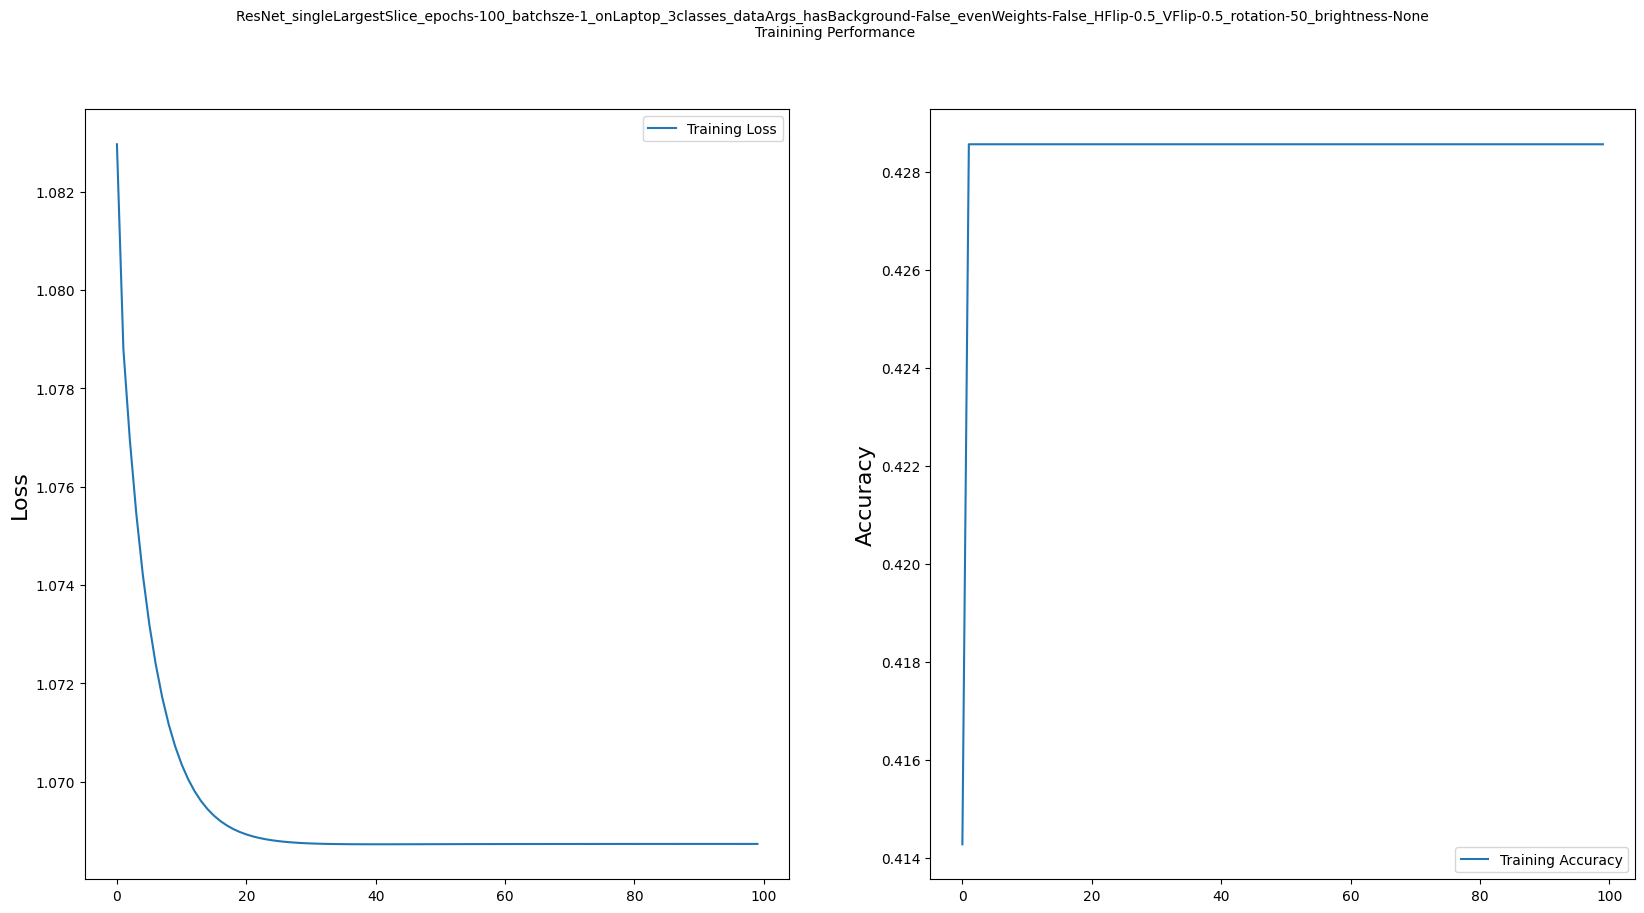

In [55]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle(f'{testName} \nTrainining Performance', fontsize=10)

# plt.suptitle('Accuracy', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history['train_loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history['train_acc'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

plt.savefig(testPathName+'/training_history.png')
plt.show()

### Evaluate performance on the testing set

In [56]:
# Look into only using images of class 0
idx = 0
for image, label in testingData:
    if label == 0:  
        # print(image)
        print(label, idx)
    idx+=1
    


tensor([0], dtype=torch.int32) 5
tensor([0], dtype=torch.int32) 6
tensor([0], dtype=torch.int32) 13
tensor([0], dtype=torch.int32) 14


In [57]:
# tempDataLoader = 
# Evaluate the model on the testing set
test_loss, test_acc, predictions= evaluateOnTest(model, testingData, criterion, device)

print(test_acc)
print(predictions)

# predictions = model.predict(xTest, batch_size=1)
# y_predict = np.argmax(predictions,axis=1)
# predicts = {0:0,1:0,2:0}
# for pred in y_predict:
#     predicts[pred]+=1
# print('Predictions:')
# print(predicts)

# ans = {0:0,1:0,2:0}
# for pred in yTest:
#     ans[pred]+=1
# print('Actual answers:')
# print(ans)

# result = confusion_matrix(yTest,y_predict,normalize='pred')
# disp = ConfusionMatrixDisplay(result)
# disp.plot()
# plt.savefig(testName+'/confusion_matrix.png')
# plt.show()

# accuracy = accuracy_score(yTest, y_predict)
# f1 = f1_score(yTest, y_predict, average='weighted')  # Use 'weighted' for multiclass classification
# recall = recall_score(yTest, y_predict, average='weighted')  # Use 'weighted' for multiclass classification


# testingMetrics = {'Accuracy':accuracy, 'F1 Score':f1, 'Recall':recall}
# file = open(testName+'/testingMetrics.txt','w')
# for key, value in testingMetrics.items():
#     file.write(f'{key}: {value}\n')
# file.close()




d:\SimpsonLab\.venv\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.4666666666666667
[tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1], device='cuda:0')]
